In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
from scipy import stats

# 1.

In [2]:
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * np.sin(1.27*dm2*l/energy)**2 

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)

    liste=[]
    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            
            i=i+1
            liste.append([e,c,int(event_random)])
    data = pd.DataFrame(liste, columns=['energy', 'cosdec', 'events'])
    return data

In [3]:
def dataset(steps, sin2theta=0.9, dm2=2.4e-3, Plotten=False):
    cosdec =  np.linspace(0, 1, steps) # n steps in cos(declination) from 0 to 1 
    log10_energy = np.linspace(1, 2, steps) # n steps in log10(energy) from 10 to 100 GeV
    energy=10**log10_energy
    # run the experiment 
    data=run_experiment(energy,cosdec,sin2theta,dm2)

    if Plotten==True:
        plt.hist(data['events'], bins=20)
        plt.yscale('log')
        plt.show() 

    return data
data = dataset(10)

In [4]:
def simulation(N):
    a = np.zeros(N)
    for i in range(len(a)):
        def chi2(sin2theta, dm2):
            energy, cosdec, events = data["energy"], data["cosdec"], data["events"]
            model_events = atmo_event_rate(energy, cosdec, sin2theta, dm2)
            chi2 = np.sum((events - model_events)**2 / model_events)
            return chi2

        data = dataset(5)
        res = Minuit(chi2, sin2theta=0.9, dm2=2.4e-3)
        res.migrad()
        a[i] = res.fval
    mean = np.mean(a)
    std = np.std(a)

    h = np.histogram(a, bins=50)
    binwidth = h[1][1]-h[1][0]
    binheight = h[0]/np.sum(h[0])

    chi2_pdf = stats.chi2.pdf(h[1][:-1], df=22)
    plt.plot(h[1][:-1], chi2_pdf,'k', label="chi2 pdf")
    plt.bar(h[1][:-1],binheight,binwidth, label="chi2 distribution")
    
    plt.axvline(mean+std, color="red", label="mean + std")
    plt.axvline(mean-std, color="red", label="mean - std")
    plt.axvline(mean, color="green", label=f"mean={mean:.2f}")
    #plt.vlines([mean + std, mean - std], 0, 1, transform=plt.gca().transAxes, label="sigma")
    plt.xlabel("$\chi^2$")
    plt.ylabel("probability")
    plt.legend()
    plt.show()
    print(f"mean = {mean:.2f} +- {std:.2f}")
    print(f"variance = {std**2:.2f}")
    return a, np.mean(a), np.std(a)

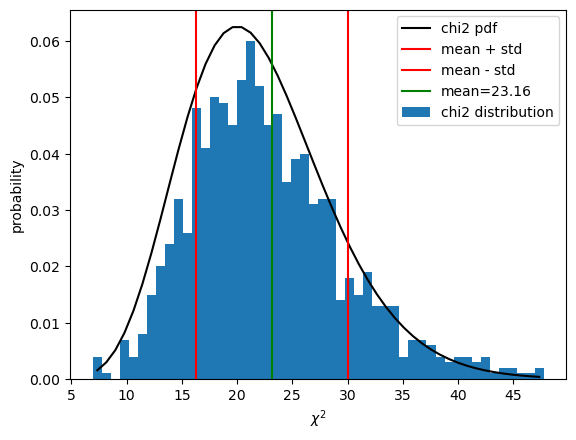

mean = 23.16 +- 6.85
variance = 46.95


In [5]:
out = simulation(1000)

# 2

In [6]:
def positive(sick, positive_sick, positive_healthy):
    num = (1-sick) * positive_healthy
    den = sick*(positive_sick-positive_healthy) + positive_healthy
    return num/den

def negative(sick, positive_sick, positive_healthy):
    num = (1-sick) * (1-positive_healthy)
    den = ((1-positive_sick)-(1-positive_healthy)) * sick + (1-positive_healthy)
    return num/den

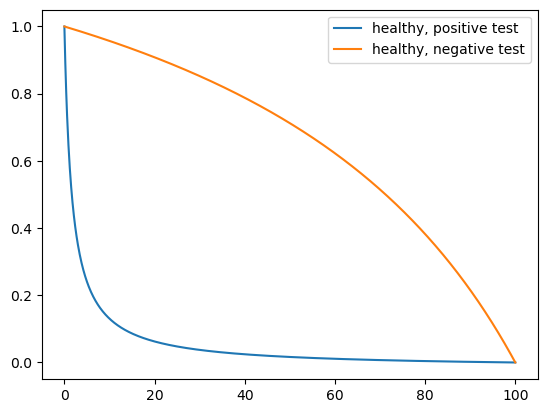

In [7]:
sick = np.linspace(1e-6,1,1000) # array of different COVID prevalences

plt.plot(sick*100, positive(sick, 0.6, 0.01), label="healthy, positive test")
plt.plot(sick*100, negative(sick, 0.6, 0.01), label="healthy, negative test")
plt.legend()
plt.show()